<a href="https://colab.research.google.com/github/arjun-gangwar/Geneartive-Adversarial-Networks/blob/master/GAN_CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


## Import Utilities

In [3]:
token = {"username":"Enter Kaggle Username","key":"Enter Your Kaggle Secret Key"}
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import json
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Download and Extract Dataset from Kaggle

In [0]:
!mkdir .kaggle

In [0]:
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle config set -n path -v{/content}

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets list

In [0]:
!kaggle datasets list -s CelebFaces

In [0]:
!kaggle datasets download -d jessicali9530/celeba-dataset -p /content

In [0]:
!unzip \*.zip

## Explore Dataset

In [0]:
def load_image(filename):
  image = Image.open(filename)
  image = image.convert('RGB')
  image = np.array(image)
  return image

In [14]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 8.7MB/s 


In [15]:
from mtcnn.mtcnn import MTCNN

Using TensorFlow backend.


In [0]:
def extract_face(model, image, required_size=(80, 80)):
  faces = model.detect_faces(image)
  if(len(faces) == 0):
    return None
  x1, y1, width, height = faces[0]['box']
  x1, y1 = abs(x1), abs(y1)
  x2, y2 = x1+width, y1+height
  image = image[y1:y2, x1:x2]
  image = Image.fromarray(image)
  image = image.resize(required_size)
  image = np.array(image)
  return image

In [0]:
def load_faces(directory, n_faces):
  faces = list()
  model = MTCNN()
  for filename in os.listdir(directory):
    image = load_image(directory + filename)
    face = extract_face(model, image)
    if face is None:
      continue
    faces.append(face)
    if len(faces) >= n_faces:
      break
  faces = np.array(faces)
  return faces

In [0]:
def plot_faces(faces, n):
  plt.figure(figsize=(10,10))
  for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.imshow(faces[i])
    plt.xticks([])
    plt.yticks([])

In [0]:
from numpy import savez_compressed
directory = '/content/img_align_celeba/img_align_celeba/'
#faces = load_faces(directory, 50000)
#print('Loaded: ', faces.shape)

In [0]:
per_save_dir = '/content/drive/My Drive/Colab Notebooks/'
#savez_compressed(os.path.join(per_save_dir,'img_align_celeba.npz'), faces)

In [21]:
from numpy import load
data = load(os.path.join(per_save_dir,'img_align_celeba.npz')) 
faces = data['arr_0'] 
print('Loaded: ', faces.shape)

Loaded:  (50000, 80, 80, 3)


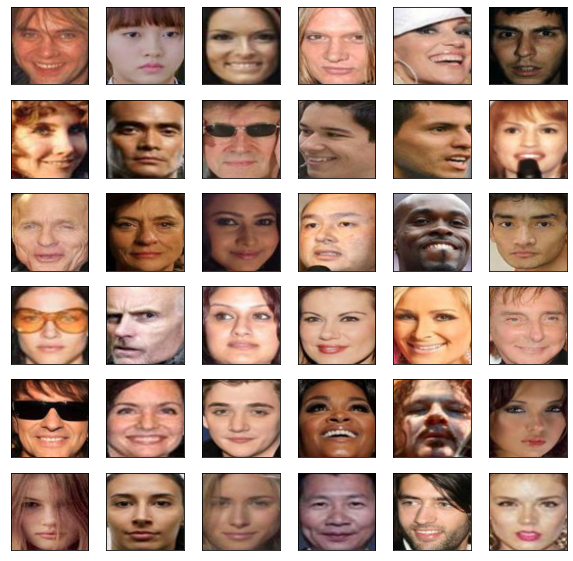

In [22]:
plot_faces(faces, 6)

## Define Discriminator

In [0]:
def define_discriminator(in_shape=(80,80,3)):
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(128, (5,5), padding='same', input_shape=in_shape))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(1, activation='sigmoid'))  
  opt = tf.keras.optimizers.Adam(lr = 0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

## Define Generator

In [0]:
def define_generator(latent_dim):
  model = tf.keras.Sequential()
  n_nodes = 128 * 5 * 5
  model.add(layers.Dense(n_nodes, input_dim=latent_dim))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Reshape((5, 5, 128)))
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) 
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) 
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) 
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) 
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(3, (5,5), activation='tanh', padding='same')) 
  return model

## Define GAN

In [0]:
def define_gan(g_model, d_model):
  d_model.trainable = False
  model = tf.keras.Sequential()
  model.add(g_model)
  model.add(d_model)
  opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5) 
  model.compile(loss='binary_crossentropy', optimizer=opt) 
  return model

## Utility Functions

In [0]:
def load_real_samples():
  data = load(os.path.join(per_save_dir,'img_align_celeba.npz'))
  X = data['arr_0']
  X = X.astype('float32')
  X = (X - 127.5) / 127.5
  return X

In [0]:
def generate_real_samples(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[ix] 
  y = np.ones((n_samples, 1))
  return X, y

In [0]:
def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [0]:
def generate_fake_samples(g_model, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  X = g_model.predict(x_input)
  y = np.zeros((n_samples, 1)) 
  return X, y

In [0]:
def save_plot(examples, epoch, n=7):
  examples = (examples + 1) / 2.0
  for i in range(n * n):
    plt.subplot(n, n, 1 + i) 
    plt.imshow(examples[i])
    plt.xticks([])
    plt.yticks([])
  filename = 'generated_plot_e%03d.png' % (epoch+1) 
  plt.savefig(filename)
  plt.close()

In [0]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
  X_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  save_plot(x_fake, epoch)
  filename = 'generator_model_%03d.h5' % (epoch+1) 
  g_model.save(filename)

## Train GAN

In [0]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    if (i+1) % 10 == 0:
     summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [0]:
dataset = load_real_samples()

In [34]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>88, 74/390, d1=0.475, d2=0.323 g=2.258
>88, 75/390, d1=0.413, d2=0.545 g=2.302
>88, 76/390, d1=0.418, d2=0.234 g=2.036
>88, 77/390, d1=0.398, d2=0.465 g=1.950
>88, 78/390, d1=0.375, d2=0.527 g=2.248
>88, 79/390, d1=0.448, d2=0.313 g=2.161
>88, 80/390, d1=0.406, d2=0.377 g=2.056
>88, 81/390, d1=0.346, d2=0.335 g=2.087
>88, 82/390, d1=0.324, d2=0.387 g=1.987
>88, 83/390, d1=0.456, d2=0.445 g=2.199
>88, 84/390, d1=0.356, d2=0.300 g=1.968
>88, 85/390, d1=0.261, d2=0.430 g=2.061
>88, 86/390, d1=0.246, d2=0.293 g=2.520
>88, 87/390, d1=0.408, d2=0.289 g=2.048
>88, 88/390, d1=0.399, d2=0.624 g=2.184
>88, 89/390, d1=0.437, d2=0.282 g=2.300
>88, 90/390, d1=0.383, d2=0.318 g=2.509
>88, 91/390, d1=0.408, d2=0.471 g=2.287
>88, 92/390, d1=0.460, d2=0.449 g=2.206
>88, 93/390, d1=0.536, d2=0.381 g=2.077
>88, 94/390, d1=0.432, d2=0.549 g=2.318
>88, 95/390, d1=0.408, d2=0.305 g=2.601
>88, 96/390, d1=0.494, d2=0.468 g=2.358
>88, 97/390, d1=0.581, d2=0.4